In [1]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import setGPU
from importlib import reload
import mplhep as hep

import data.data_reader as dare
import data.preprocessing as prep
import data.graph_construction as grctr
import data.constant_dicts as codi
import models.graph_nn as grap
import analysis.plotting as plott

setGPU: Setting GPU to: 0


In [2]:
%load_ext autoreload
%autoreload 2

# read in data

In [3]:
# set dataset and sample to use
sample_id = 'events'
qcd_id = 'qcd_side'

In [4]:
input_dir = codi.sample_dict['dir_paths'][sample_id][qcd_id]
file_name = codi.sample_dict['file_names'][sample_id][qcd_id]
file_path = os.path.join(input_dir, file_name)

In [5]:
print('reading ', file_path)

reading  /eos/cms/store/group/ml/AnomalyHackathon/VAE/samples/v1/qcd/merged/flat_scouting_1_numEvent500_event.h5


In [7]:
reload(dare)
samples = dare.read_dijet_samples_from_file(file_path) if sample_id == 'dijet' \
            else dare.read_event_samples_from_file(file_path)

In [24]:
#samples = samples[:2000]

In [8]:
samples.shape

(204000, 52, 6)

In [14]:
feature_names = codi.sample_dict['feature_names'][sample_id]
print(feature_names)

['px', 'py', 'pz', 'pt', 'eta', 'phi']


In [16]:
# mask events with ojects having pt > 13000
pt_idx = feature_names.index('pt')
if sample_id == 'events':
    pz_idx = feature_names.index('pz')
    samples = prep.mask_events_outliers(samples, [pt_idx, pz_idx], [5e3, 5e3])

In [17]:
samples.shape

(203981, 52, 6)

### sparsity

In [18]:
particles_n = samples.shape[0]*samples.shape[1]
true_particles_n = sum(samples[:,:,pt_idx].flatten() > 0)
print('num total particles ', particles_n)
print('num true particles', true_particles_n)
print('true particles share ', (float(true_particles_n)/float(particles_n))*100.0)

num total particles  10607012
num true particles 2536931
true particles share  23.91748967569755


## normalize

In [19]:
reload(prep)
samples = prep.normalize_features(samples, feature_names)

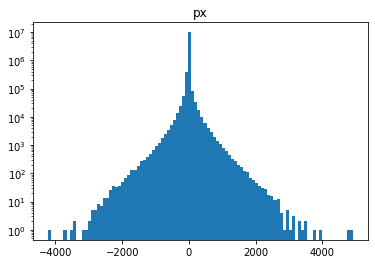

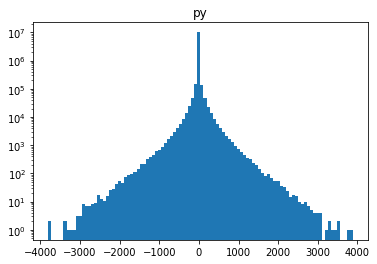

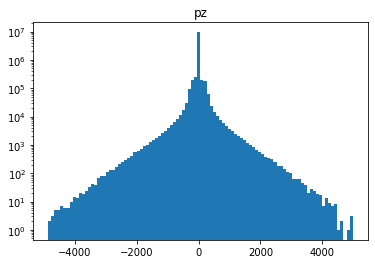

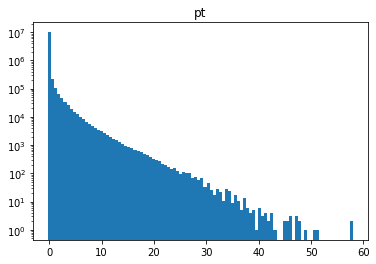

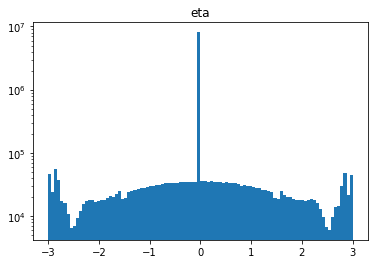

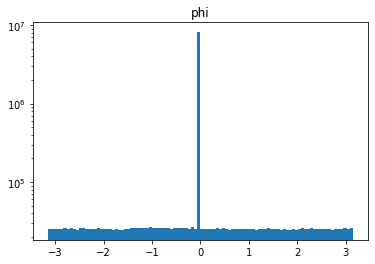

In [21]:
for i in range(samples.shape[2]):
    plt.figure()
    _ = plt.hist(samples[:,:,i].flatten(), bins=100)
    plt.title(feature_names[i])
    plt.yscale('log')

# prepare input for model

In [22]:
nodes_n = samples.shape[1]
feat_sz = samples.shape[2]

In [23]:
batch_size = 128

In [24]:
reload(grctr)
A = grctr.make_adjacencies(samples, pt_idx=pt_idx)
A_tilde = grctr.normalized_adjacency(A)

/eos/home-k/kiwoznia/dev/graph_vae_ada/gravada/data/graph_construction.py:6: RuntimeWarning: divide by zero encountered in power
  D = np.nan_to_num(np.power(D,-0.5), posinf=0, neginf=0) # normalize (**-(1/2))


# build and train model

In [25]:
reload(grap)
gnn = grap.GraphAutoencoder(nodes_n=nodes_n, feat_sz=feat_sz, activation=tf.nn.selu, graphLayer='convExt')
gnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), run_eagerly=True)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_features (InputLa [(None, 52, 6)]      0                                            
__________________________________________________________________________________________________
encoder_input_adjacency (InputL [(None, 52, 52)]     0                                            
__________________________________________________________________________________________________
graph_convolution_expanded (Gra (None, 52, 5)        659         encoder_input_features[0][0]     
                                                                 encoder_input_adjacency[0][0]    
__________________________________________________________________________________________________
graph_convolution_expanded_1 (G (None, 52, 4)        544         graph_convolution_expa

In [26]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, verbose=1), tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, verbose=1)]
gnn.fit((samples, A_tilde), A, epochs=100, batch_size=128, validation_split=0.25, callbacks=callbacks)

Epoch 1/100
1196/1196 [==============================] - 31s 26ms/step - val_loss: 0.6766
Epoch 2/100
1196/1196 [==============================] - 31s 26ms/step - val_loss: 0.6766
Epoch 3/100
1196/1196 [==============================] - 31s 26ms/step - val_loss: 0.6766
Epoch 4/100
1196/1196 [==============================] - 30s 25ms/step - val_loss: 0.6766
Epoch 5/100
1196/1196 [==============================] - 33s 27ms/step - val_loss: 0.6766
Epoch 6/100
1195/1196 [============================>.] - ETA: 0s
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
1196/1196 [==============================] - 34s 28ms/step - val_loss: 0.6766
Epoch 7/100
1196/1196 [==============================] - 32s 27ms/step - val_loss: 0.6766
Epoch 00007: early stopping


## predict background

In [28]:
reload(codi)
qcd_id_test = 'qcd_sig'
input_dir_qcd_test = codi.sample_dict['dir_paths'][sample_id][qcd_id_test]
file_name_qcd_test = codi.sample_dict['file_names'][sample_id][qcd_id_test]
file_path_qcd_test = os.path.join(input_dir_qcd_test, file_name_qcd_test)
print('reading ', file_path_qcd_test)

reading  /eos/cms/store/group/ml/AnomalyHackathon/VAE/samples/v1/qcd/merged/flat_scouting_6_numEvent500_event.h5


In [35]:
samples_qcd_test = dare.read_dijet_samples_from_file(file_path) if sample_id == 'dijet' \
            else dare.read_event_samples_from_file(file_path)
print(samples_qcd_test.shape)

(204000, 52, 6)


In [36]:
samples_qcd_test = prep.normalize_features(samples_qcd_test, feature_names)
samples_qcd_test = samples_qcd_test[:3000]
print(samples_qcd_test.shape)

(3000, 52, 6)


In [37]:
A_qcd_test = grctr.make_adjacencies(samples_qcd_test, pt_idx=pt_idx)
A_qcd_test_tilde = grctr.normalized_adjacency(A_qcd_test)

In [38]:
z_qcd, A_qcd_pred = gnn((samples_qcd_test, A_qcd_test_tilde))
#A_qcd_reco = (tf.nn.sigmoid(A_qcd_pred) > 0.5).numpy().astype('int')

In [39]:
loss_qcd = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_qcd_test, A_qcd_pred), axis=(1,2)).numpy()

## predict signal

In [40]:
signal_ids = ['grs35na', 'grs35br'] if sample_id == 'dijet' else ['grs', 'zprime', 'sms']
signal_losses = []

for sig_id in signal_ids:
    
    # read signal files
    file_num = np.random.randint(9)
    file_dir = codi.sample_dict['dir_paths'][sample_id][sig_id]
    file_name = codi.sample_dict['file_names'][sample_id][sig_id]
    file_path_signal = os.path.join(file_dir, file_name)
    print('predicting ', file_path_signal)
    samples_signal_test = dare.read_dijet_samples_from_file(file_path_signal) if sample_id == 'dijet' \
                            else dare.read_event_samples_from_file(file_path_signal)
    
    # preprocess
    #samples_signal_test = prep.mask_events_outliers(samples_signal_test, [pt_idx, pz_idx], [5e3, 5e3])
    samples_signal_test = prep.normalize_features(samples_signal_test, feature_names)
    samples_signal_test = samples_signal_test[:10000]
    print(samples_signal_test.shape)
    
    # make adjacencies
    A_signal_test = grctr.make_adjacencies(samples_signal_test, pt_idx=pt_idx)
    A_signal_test_tilde = grctr.normalized_adjacency(A_signal_test)
    
    # run inference
    z_signal, A_signal_pred = gnn((samples_signal_test, A_signal_test_tilde))
    #A_signal_reco = (tf.nn.sigmoid(A_signal_pred) > 0.5).numpy().astype('int')
    loss_signal = tf.math.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(A_signal_test, A_signal_pred), axis=(1,2)).numpy()
    signal_losses.append(loss_signal)

predicting  /eos/cms/store/group/ml/AnomalyHackathon/VAE/samples/v1/BulkGraviton_hh_GF_HH/merged/flat_scouting_1_numEvent500_event.h5
(10000, 52, 6)
predicting  /eos/cms/store/group/ml/AnomalyHackathon/VAE/samples/v1/ZprimeToZH_MZprime1000_MZ50_MH80_narrow/merged/flat_scouting_2_numEvent500_event.h5
(7000, 52, 6)
predicting  /eos/cms/store/group/ml/AnomalyHackathon/VAE/samples/v1/SMS-T1qqqq/merged/flat_scouting_3_numEvent500_event.h5
(10000, 52, 6)


# plot loss distributions and ROC

In [41]:
loss_qcd.shape
print(min(loss_qcd))

0.6931472


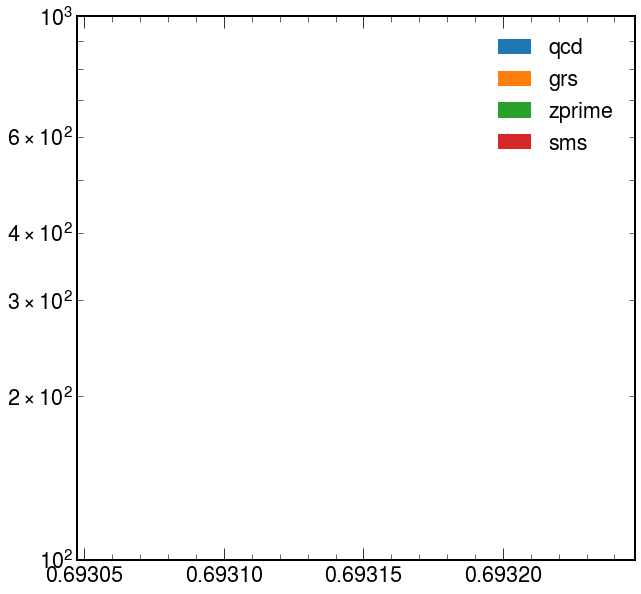

In [50]:
plt.style.use(hep.style.CMS)
_ = plt.hist([loss_qcd.flatten(), *signal_losses], bins=100, label=['qcd']+signal_ids, histtype='bar', density=True)
plt.xlim(np.min(loss_qcd-1e-4),np.max(loss_qcd+1e-4))
plt.yscale('log')
plt.legend()

In [48]:
print(min(loss_qcd), max(loss_qcd))

0.6931472 0.6931472


In [49]:
print(min(loss_signal), max(loss_signal))

0.6931472 0.6931472


In [54]:
len(signal_losses)

2

/eos/home-k/kiwoznia/dev/graph_vae_ada/gravada/analysis/plotting.py:86: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")", color=color)
/eos/home-k/kiwoznia/dev/graph_vae_ada/gravada/analysis/plotting.py:86: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(tpr, 1./fpr, label=label + " (auc " + "{0:.3f}".format(aucs[-1]) + ")", color=color)
/eos/home-k/kiwoznia/dev/graph_vae_ada/gravada/analysis/plotting.py:92: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(np.linspace(0, 1, num=100), 1./np.linspace(0, 1, num=100), linewidth=1.2, linestyle='solid', color='silver')


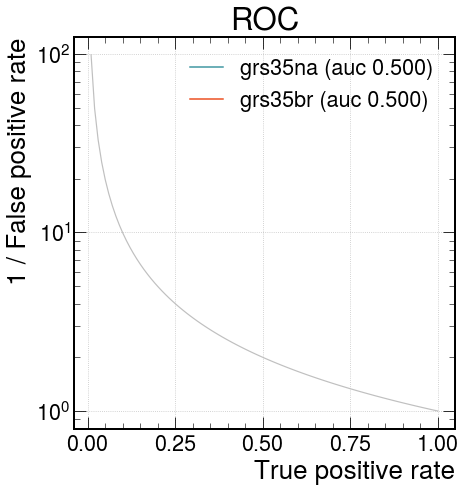

[0.5, 0.5]

In [56]:
reload(plott)
plott.plot_roc([loss_qcd]*3, signal_losses, legend=signal_ids, log_x=False)

In [56]:
q99 = np.poly1d([-7.03032980e-11, 1.06542864e-06, -2.17139299e-03, 3.31447885e+00])

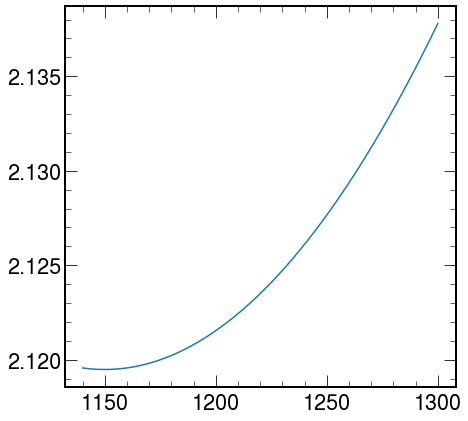

In [65]:
mJJ = np.linspace(1140,1300,50)
plt.figure(figsize=(7,7))
plt.plot(mJJ, q99(mJJ))